In [1]:
library(data.table)
library(ggplot2)
library(reshape2)
library(dplyr)
library(randomForest) # regression tree
library(car)

Warning message:
"package 'data.table' was built under R version 3.6.3"
Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Warning message:
"package 'reshape2' was built under R version 3.6.3"

Attaching package: 'reshape2'


The following objects are masked from 'package:data.table':

    dcast, melt


Warning message:
"package 'dplyr' was built under R version 3.6.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'randomForest' was built under R version 3.6.3"
randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:dplyr':

    combine


The following object is masked from 'package:ggplot2':

    margin


In [2]:
YEARLIST =c("19","20")
MONTHLIST = c("01", "02", "03", "04", "05", "06", "07", "08", "09", "10","11","12")
COMPUTATION_FILEPATH = "F:/data/tidy/trajectory-aggregation-line-specific/"
# Data input
aggregation_data_input = function(YEARLIST,MONTHLIST,lineid){
    df = data.table()
    for (y in YEARLIST) {
         for (m in MONTHLIST) {
             assign("d",fread(paste0(COMPUTATION_FILEPATH, paste(paste("trajectory", "aggregation" , y , m , lineid, sep = "-", collapse = ""), ".csv", sep=""))))
             df = rbind(df,d)
             }
        }
    df= df %>% rename_all(.,~sub("speed_bin_*", 
                        paste("S"),
                        names(df)))
    df = df %>% rename_all(.,~sub("accel_bin_*", 
                        paste("A"),
                        names(df)))
    return(df)
}
agg_data_1 = aggregation_data_input(YEARLIST,MONTHLIST,1)
agg_data_2 = aggregation_data_input(YEARLIST,MONTHLIST,2)
agg_data_3 = aggregation_data_input(YEARLIST,MONTHLIST,3)
agg_data_4 = aggregation_data_input(YEARLIST,MONTHLIST,4)

In [36]:
# agg_data_1 = fread("../../data/tidy/agg_data_1.csv")
# agg_data_2 = fread("../../data/tidy/agg_data_2.csv")
# agg_data_3 = fread("../../data/tidy/agg_data_3.csv")
# agg_data_4 = fread("../../data/tidy/agg_data_4.csv")
# agg_data_1 = agg_data_1[,-1]
# agg_data_2 = agg_data_2[,-1]
# agg_data_3 = agg_data_3[,-1]
# agg_data_4 = agg_data_4[,-1]

In [3]:
# Simplify the variables name
rename = function(df, lineid)
    {
    colnames(df)[names(df) == 'avg_hour_speed_mph'] <- paste0('avg_hour_speed_mph_', lineid)
    colnames(df)[names(df) == 'avg_interval_speed_mph'] <- paste0('avg_interval_speed_mph_', lineid)
    colnames(df)[names(df) == 'distance_mile'] <- paste0('distance_mile_', lineid)
    colnames(df)[names(df) == 'time_hr'] <- paste0('time_hr_', lineid)
    names(df)[names(df) == lineid] = paste0('num_', lineid)  
    return(df)
}

In [4]:
# rename the variables with lineid
agg_data_1 = rename(agg_data_1, 1)
agg_data_2 = rename(agg_data_2, 2)
agg_data_3 = rename(agg_data_3, 3)
agg_data_4 = rename(agg_data_4, 4)
agg_data = merge(agg_data_1, agg_data_2, all = TRUE)
agg_data = merge(agg_data, agg_data_3, all = TRUE)
agg_data = merge(agg_data, agg_data_4, all = TRUE)

In [5]:
# data split for model estimation
set_split = function(df){
    df$weekends = as.factor(df$weekends)
    df$num_trains = df$num_1 + df$num_2 + df$num_3 + df$num_4
    df$month_factor = as.factor(df$month)
    df$TAVG_squared = I(df$TAVG^2)
    # remove all 0 variable
    #df = df[,-"speed_bin_1_accel_bin_6_time_hr"]
    set.seed(1234)
    train = df[year == 2019,]
#     df_2019 = df[year == "2019",]
#     rate = 0.8
#     sub = sample(1:nrow(df_2019),round(nrow(df_2019)*rate)) # the split ratio is 0.8
#     train = df_2019[sub,] # train set
#     validation = df_2019[-sub,] # validation set
    test = df[year ==  2020,] # test set
    train[is.na(train)] <- 0
    return(list(df_train = train, 
#                 df_validate = validation, 
                df_test = test))

}
dfh_train = set_split(agg_data)$df_train
# dfh_validation = set_split(agg_data)$df_validate
dfh_test = set_split(agg_data)$df_test

In [6]:
# Save all observations in one list and we will input the list into to RF function
name_list = names(dfh_train)
x_list = name_list[-c(1, 2, 3, 4, 5, 9)]     

In [16]:
# Random ratio 
# Find the best parameters by next week
dfh_train_1 = dfh_train[sub,]
dfh_test_1 = dfh_test[sub_test,]

In [15]:
rate = 0.8
sub = sample(1:nrow(dfh_train),round(nrow(dfh_train)*rate)) 
sub_test = sample(1:nrow( dfh_test),round(nrow(dfh_test)*rate)) 

In [18]:
ntree_list = c(200,500,800,1000)
mtry_list = c(80, 100,120,140,160,180,200)
error_df = data.frame("mtry"= rep(NA, length(mtry_list)),"ntree" = rep(NA, length(mtry_list)))
error_df_results = data.frame()
# Create a dataframe for saving the hyperparameters index
for (NTREE in ntree_list){
    error_df$ntree = NTREE 
    error_df$mtry = mtry_list 
    error_df_results = rbind(error_df_results,error_df)
 }
error_df_results$oob_errors = NA
error_df_results$predict_errors= NA

In [ ]:
# mtry is no of Variables randomly chosen at each split
for (NTREE in ntree_list)
{  
     for(MTRY in mtry_list) 
  {
  rf = randomForest(reformulate(x_list,"energy_MWh") , data = dfh_train_1,  mtry = MTRY, ntree = NTREE) 
         print( rf$mse[NTREE])
  error_df_results$oob_errors[error_df_results$mtry == MTRY &
                               error_df_results$ntree == NTREE] = sqrt(rf$mse[NTREE]) #Error of all Trees fitted    
  # train errors
  pred = predict(rf,dfh_test_1，na.action = pass) # Predictions on Test Set for each Tree
  error_df_results$predict_errors[error_df_results$mtry == MTRY &
                               error_df_results$ntree == NTREE] = with(dfh_test_1, sqrt(mean((energy_MWh - pred)^2,na.rm = TRUE)))
  print(MTRY)
  print(NTREE)
  }
}

In [12]:
error_df_results_melt = melt(error_df_results, id.vars = c("mtry","ntree"), measure.vars = c("oob_errors","predict_errors"))

In [13]:
error_df_results_melt

mtry,ntree,variable,value
<dbl>,<dbl>,<fct>,<dbl>
80,200,oob_errors,2.651036
100,200,oob_errors,2.604808
120,200,oob_errors,2.616385
140,200,oob_errors,2.590446
160,200,oob_errors,2.590497
180,200,oob_errors,2.596558
200,200,oob_errors,2.615015
80,500,oob_errors,2.644107
100,500,oob_errors,2.615731


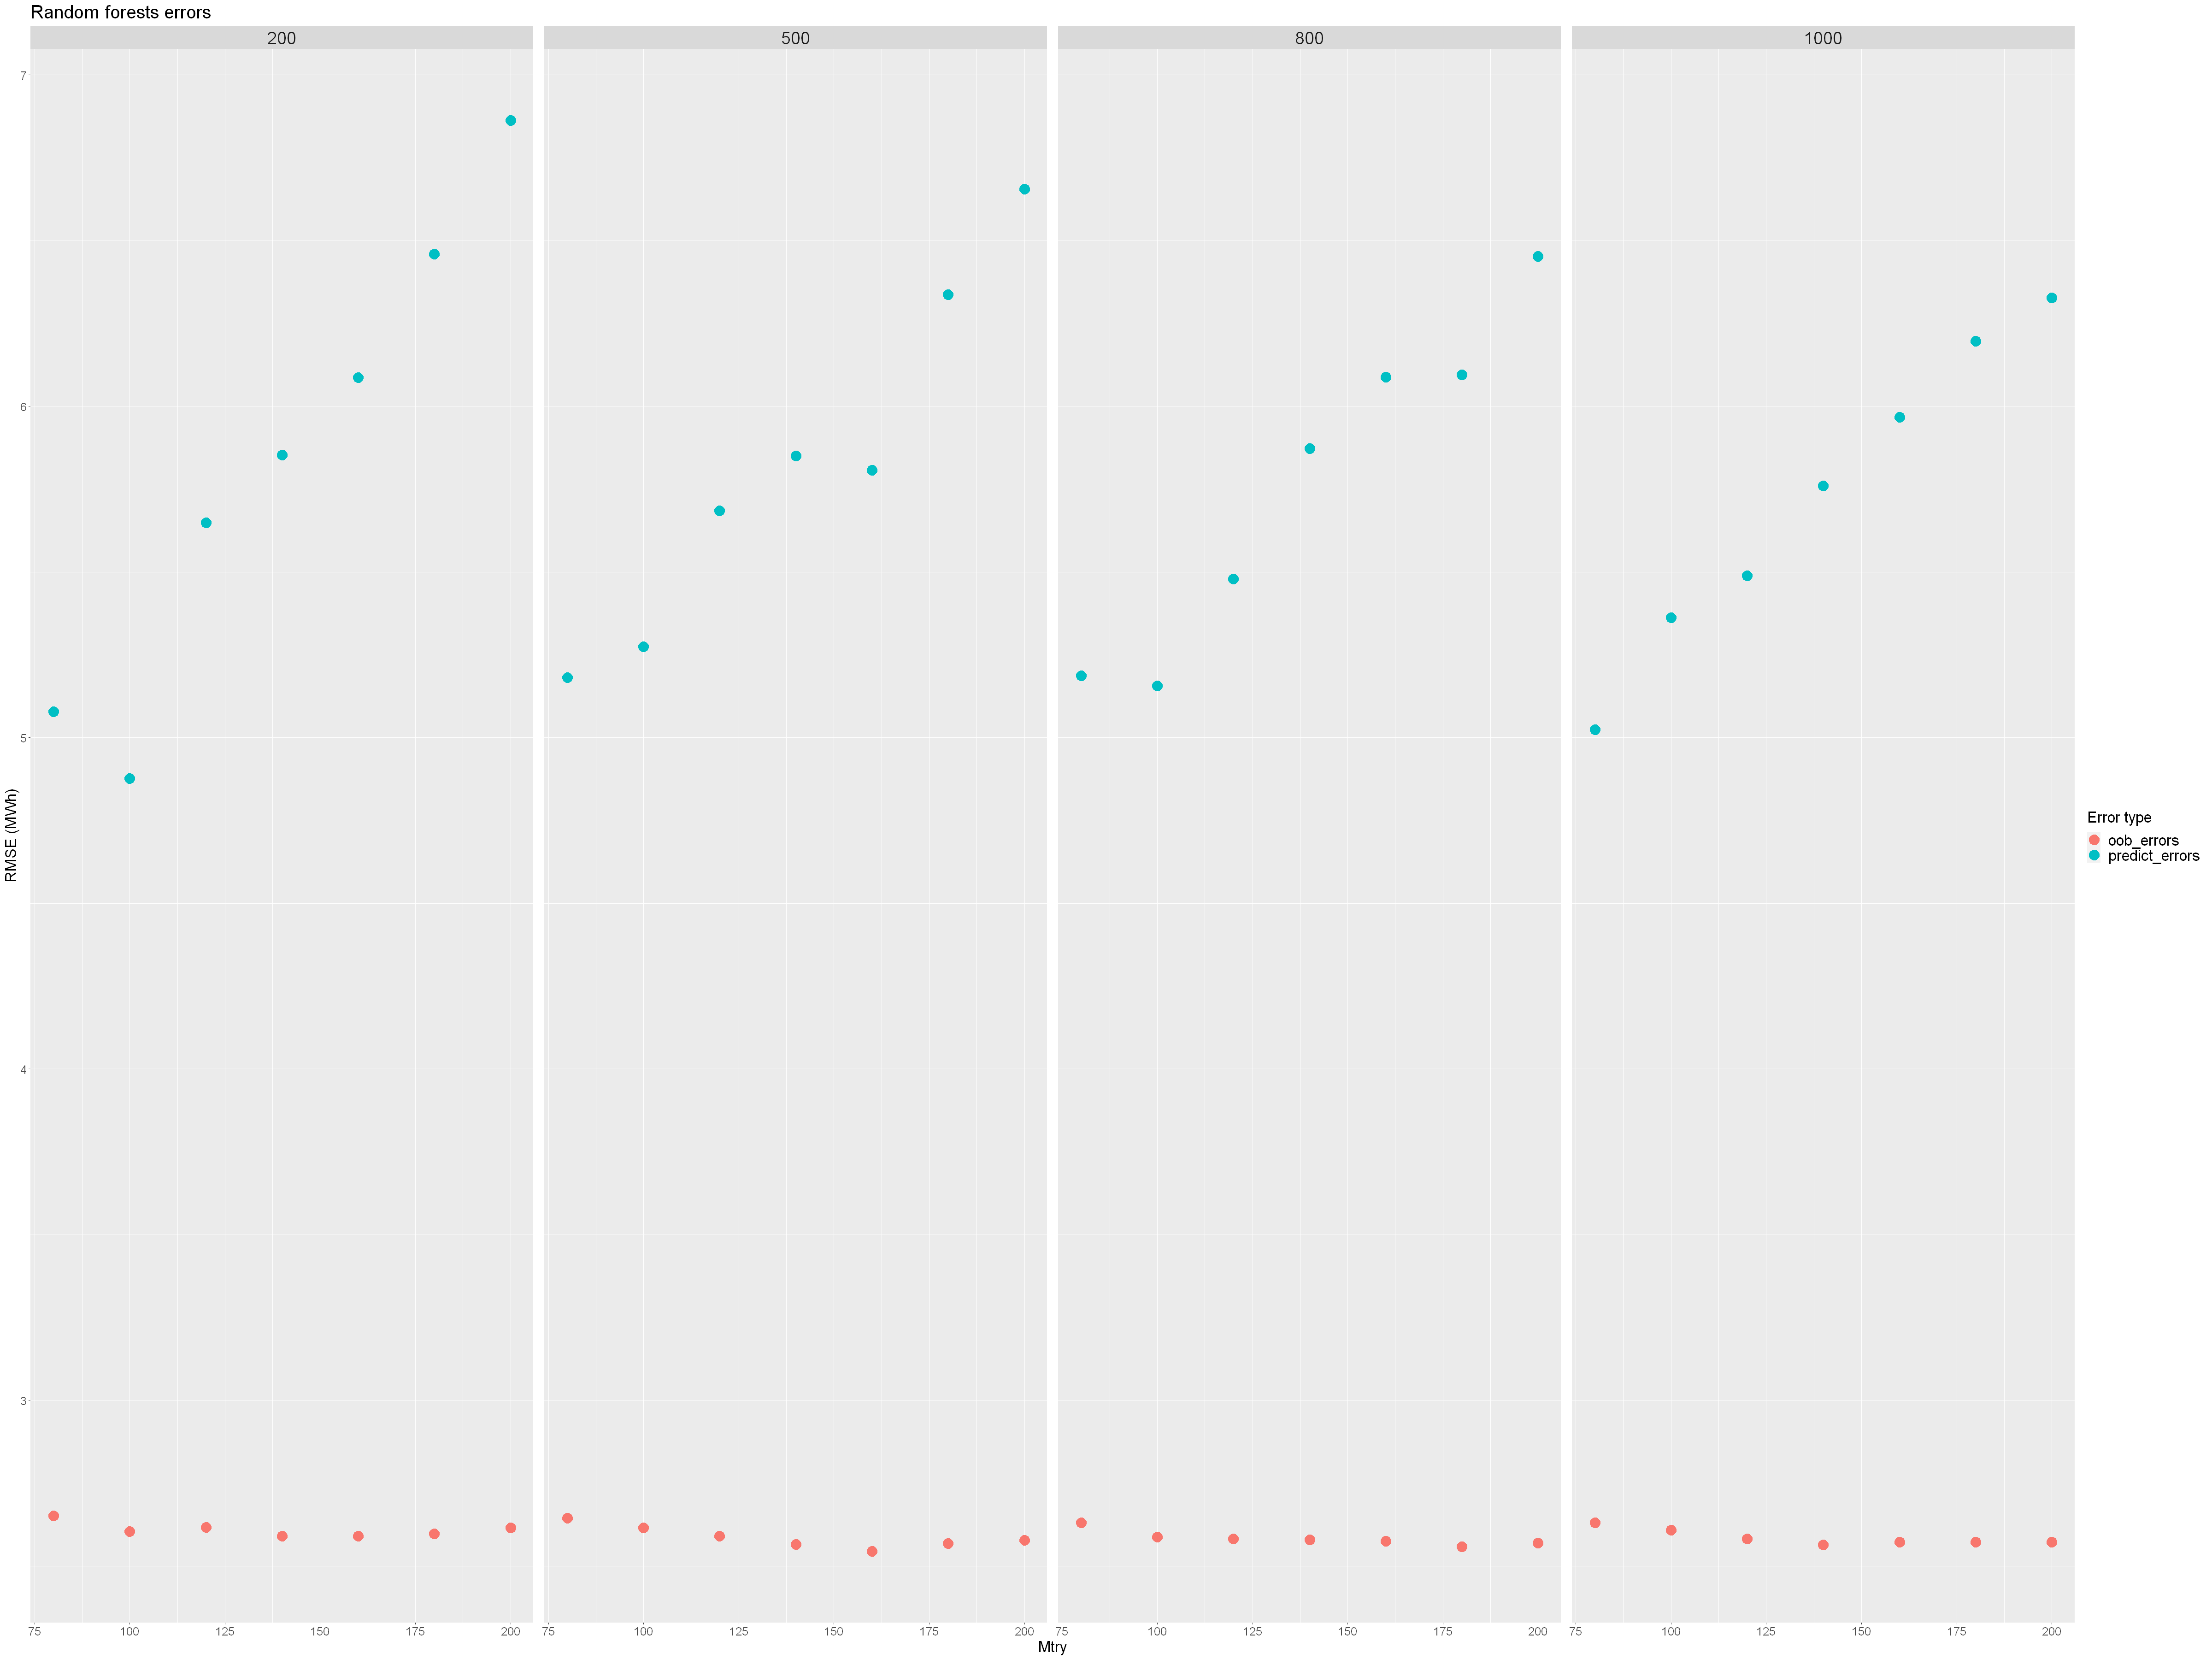

In [14]:
# same row; y axis should be shared
options(repr.plot.width = 40, repr.plot.height = 30)
ggplot(error_df_results_melt,aes(x = mtry, y = value, color = variable)) + 
    geom_point(size = 6) + 
    facet_wrap(~ntree,nrow = 1) +
#                scales = "free_y") 
    labs(title = "Random forests errors ", x = "Mtry", y = "RMSE (MWh)", color = "Error type") +
    theme(strip.text = element_text(size = rel(2)),
          axis.title.x = element_text(size = 20),
          axis.title.y = element_text(size = 20),
          title= element_text(size = 20),
          axis.text.x = element_text(size = 15),
          axis.text.y = element_text(size = 15)，
          panel.spacing = unit(1, "lines"),
          legend.text = element_text(size = 20))

In [ ]:
plot(x = error_df_results$mtry, y )

In [31]:
png("../../figures/test_train_error.png",height=2000,width=2000,res=360)
matplot(1:mtry , cbind(oob.err,test.err), pch=19 , col=c("red","blue"),type="b",ylab="Mean Squared Error",xlab="Number of Predictors Considered at each Split"
       ,xlim = c(80,140))
legend("topright",legend=c("Out of Bag Error","Test Error"),pch=19, col=c("red","blue"))
dev.off()

png 
  2

# Random Forests

In [10]:
random_forest = function(split,num_trees){
#     df = data.table("mtry" = c(18,25,32,40),"OOB error"= as.numeric(),"Train error"= as.numeric())
#     seq = c(18,25,32,40)
#     mtry <- tuneRF(dfh_train[,..list1],dfh_train$energy_MWh, ntreeTry=500,
#                stepFactor=1.5,improve=0.01, trace=TRUE, plot=TRUE)
#    best.m <- mtry[mtry[, 2] == min(mtry[, 2]), 1]
#    print(mtry)
#    print(best.m)
   Random_forest_energy <- randomForest(reformulate(x_list,"energy_MWh"), data = dfh_train, mtry= split, ntree = num_trees, na.omit = TRUE)
   # Importance of each variable
   varImpPlot(Random_forest_energy , main = "variable importance")
   # Basic model information
   print(Random_forest_energy)
   # Number of nodes in each tree
   hist(treesize(Random_forest_energy))
   return(Random_forest_energy)
}


Call:
 randomForest(formula = reformulate(x_list, "energy_MWh"), data = dfh_train,      mtry = split, ntree = num_trees, na.omit = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 140

          Mean of squared residuals: 2.522041
                    % Var explained: 96.72


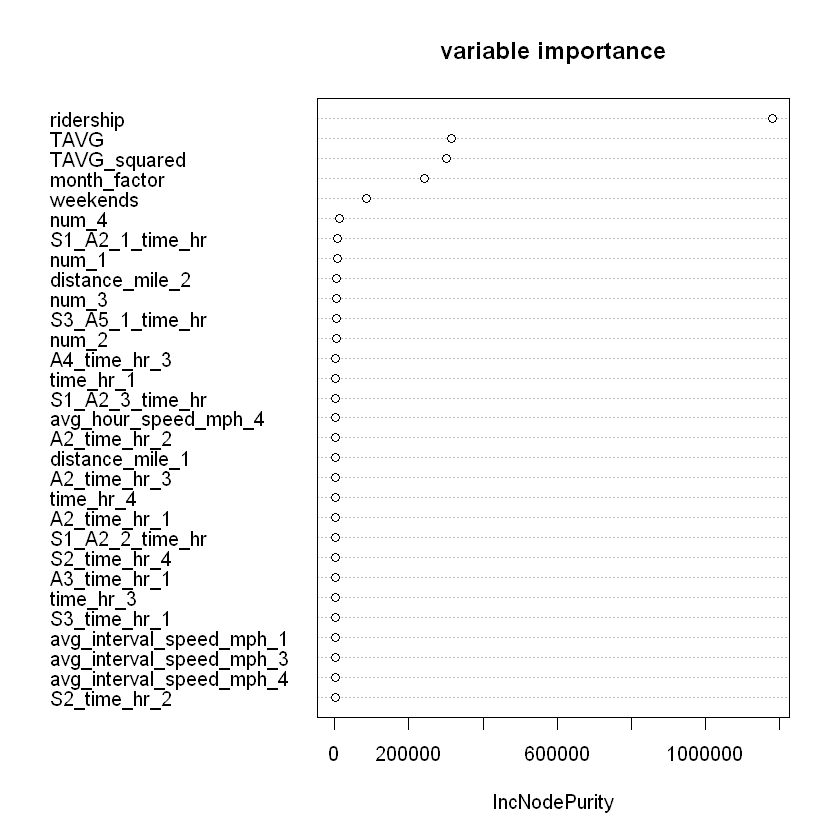

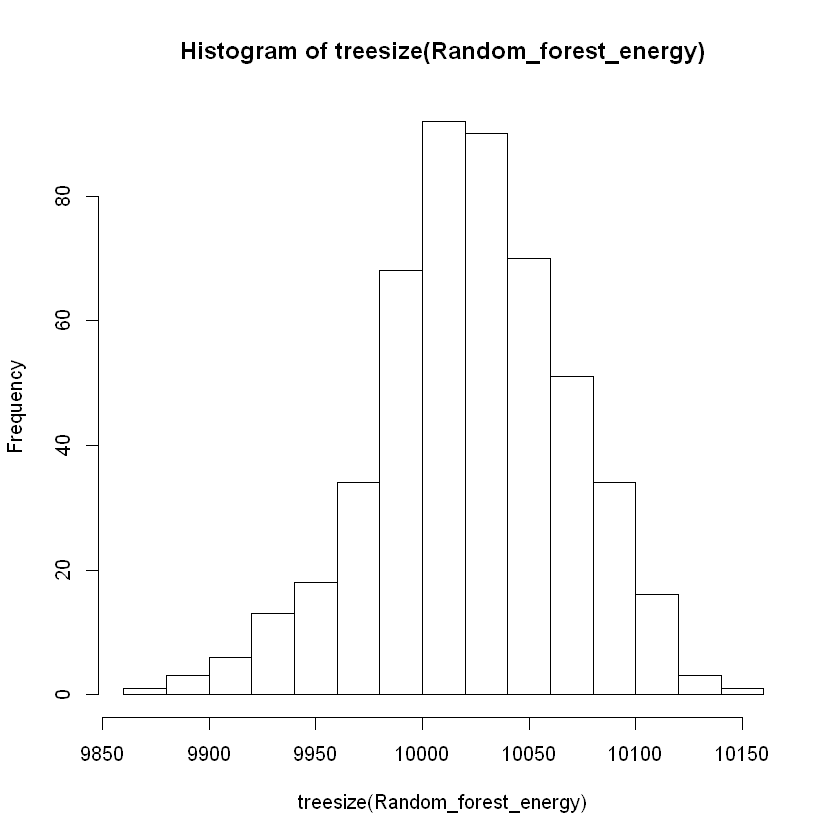

In [11]:
RF = random_forest（140，500）

In [36]:
RF$err.rate[,1]

NULL

In [14]:
dfh_test[is.na(dfh_test)] <- 0

In [16]:
RF_importance = data.frame(RF $importance)
RF_importance$ID = rownames(RF_importance)
RF_importance = RF_importance[order(RF_importance$IncNodePurity,decreasing=TRUE,na.last=FALSE),]
RF_importance = RF_importance[1:10,]
pred <- predict(RF, newdata = dfh_test) 

In [17]:
print(paste("RMSE:",sqrt(mean((dfh_test$energy_MWh - pred)^2,na.rm = TRUE))))
print(paste("MAPE:",mean(abs((dfh_test$energy_MWh - pred)/dfh_test$energy_MWh),na.rm =TRUE) * 100))
test_compare = data.frame("Observed" = dfh_test$energy_MWh, "Predicted" = pred, "Residual" =  dfh_test$energy_MWh - pred,
                          "Hour" = dfh_test$hour,"Year" = dfh_test$year,"Day"  = dfh_test$day,"Month" = dfh_test$month)
test_compare$Date = with(test_compare, ISOdatetime(Year,  Month, Day, Hour, 0, 0))
test_compare_melt = melt(test_compare,id.vars=c("Hour","Year","Day","Month","Date","Residual"),
                measure.vars = c("Predicted","Observed"),variable.name = "type",value.name = "value")

[1] "RMSE: 3.88368027882147"
[1] "MAPE: Inf"


In [26]:
test = test_compare[test_compare$Observed!=0,]

In [27]:
range(test$Observed)

[1] 23.889 68.611

In [28]:
print(paste("MAPE:",mean(abs((test$Observed - test$Predicted)/test$Observed),na.rm =TRUE) * 100))

[1] "MAPE: 7.16036682770722"


In [19]:
png("../../figures/RF_importance_line.png",height=6500,width=9600,res=360)
ggplot(RF_importance, aes(IncNodePurity/1000, reorder(ID, IncNodePurity)))+
  #xlim(-20,20) +
  geom_bar(stat="identity",fill="#1f78b4",width = 0.6) +
  theme_bw()+
  theme(axis.text=element_text(size = 35),axis.title.x = element_text(size = 40),axis.title.y = element_blank()) +
  #scale_color_gradient(low="blue",high = "red") +
  labs(x = "Increase in Node Purity (thousand)") +
  guides(color = FALSE)
dev.off()

png 
  2

In [18]:
# Model performance
png("../../figures/Random forest_line.png",height=2700,width=8000,res=360)
ggplot(test_compare_melt) + 
ylim(20,70) +
 geom_line(aes(x = Date, y = value, color = type)
           ,size = 1,alpha = 0.4) +
  geom_point(aes(x = Date , y = value, color = type)
             ,size = 1, alpha = 0.4) + 
    #geom_errorbar(aes(x = Date, y = value, ymin = CI_lower, ymax=CI_upper, color = ""), width=.2,
#                  position=position_dodge(0.05)) +
    theme_bw() + 
    theme(axis.text = element_text(size=30), axis.title.x = element_blank(),title = element_text(size=35),
         legend.text = element_text(size = 30), legend.title = element_blank(),
        axis.title.y = element_blank(),
         legend.key.size = unit(3, 'cm'),
         panel.grid = element_line(size = 0.9)) + 
    labs(#title ="Random Forests", 
      y = "Energy consumption (MWh)", x = "Date") +
   scale_x_datetime(date_breaks ="1 month",date_labels = ("%m/%y")) +
   scale_color_manual(values=c("#fc8d62", "#8da0cb"))
dev.off()

Warning message:
"Removed 5 rows containing missing values (geom_point)."


png 
  2

In [27]:
alias( lm(reformulate(x_list,"energy_MWh"),data = dfh_train) )

Model :
energy_MWh ~ ridership + weekends + TAVG + num_1 + distance_mile_1 + 
    time_hr_1 + S1_time_hr_1 + S2_time_hr_1 + S3_time_hr_1 + 
    S4_time_hr_1 + S5_time_hr_1 + S6_time_hr_1 + A1_time_hr_1 + 
    A2_time_hr_1 + A3_time_hr_1 + A4_time_hr_1 + A5_time_hr_1 + 
    A6_time_hr_1 + S1_A1_1_time_hr + S2_A1_1_time_hr + S3_A1_1_time_hr + 
    S4_A1_1_time_hr + S5_A1_1_time_hr + S6_A1_1_time_hr + S1_A2_1_time_hr + 
    S2_A2_1_time_hr + S3_A2_1_time_hr + S4_A2_1_time_hr + S5_A2_1_time_hr + 
    S6_A2_1_time_hr + S1_A3_1_time_hr + S2_A3_1_time_hr + S3_A3_1_time_hr + 
    S4_A3_1_time_hr + S5_A3_1_time_hr + S6_A3_1_time_hr + S1_A4_1_time_hr + 
    S2_A4_1_time_hr + S3_A4_1_time_hr + S4_A4_1_time_hr + S5_A4_1_time_hr + 
    S6_A4_1_time_hr + S1_A5_1_time_hr + S2_A5_1_time_hr + S3_A5_1_time_hr + 
    S4_A5_1_time_hr + S5_A5_1_time_hr + S6_A5_1_time_hr + S1_A6_1_time_hr + 
    S2_A6_1_time_hr + S3_A6_1_time_hr + S4_A6_1_time_hr + S5_A6_1_time_hr + 
    S6_A6_1_time_hr + avg_interval_speed

In [33]:
formula <- reformulate(x_list,"energy_MWh")

In [36]:
ld.vars <- attributes(alias(linear_model)$Complete)$dimnames[[1]]

In [37]:
formula.new <- as.formula(
    paste(
        paste(deparse(formula), collapse=""), 
        paste(ld.vars, collapse="-"),
        sep="-"
    )
)

In [38]:
fit.new <-lm(formula.new,data = dfh_train)

In [55]:
f = summary(fit.new)

In [77]:
linear_res = data.table(summary(fit.new)$coefficients)

In [78]:
linear_res_2 = data.frame(summary(fit.new)$coefficients)

In [80]:
linear_res$ID = rownames(linear_res_2)

In [82]:
linear_res_filter = linear_res[`Pr(>|t|)`<0.1]

In [84]:
var_list_new = linear_res_filter$ID

In [90]:
var_list_new = var_list_new[-1]

In [99]:
linear_model_filter  = lm(reformulate(var_list_new ,"energy_MWh"), data = dfh_train)

In [102]:
linear_list = data.frame(summary(linear_model_filter)$coefficients)

In [ ]:
pred_linear <- predict.lm(linear_model_filter, validation_set,interval = 'confidence')
pred_linear = data.frame(pred_linear)

In [104]:
pred_linear <- predict.lm(linear_model_filter, dfh_validation,interval = 'confidence')
pred_linear = data.frame(pred_linear)
test_compare = data.frame("Observed" = dfh_validation$energy_MWh, "Predicted" = pred_linear$fit, "CI_lower" = pred_linear$lwr,
                              "CI_upper" = pred_linear$upr, 
#                               Veh_mile" = validation_set$distance_mile, "Veh-hour" = validation_set$time_hr
                               "Hour" = dfh_validation$hour, "Year" = dfh_validation$year, "Day"  = dfh_validation$day, "Month" = dfh_validation$month, 
                              "Residual" =  dfh_validation$energy_MWh - pred_linear$fit, "Set" = "")
 MSE = sqrt(mean((test_compare$Observed - test_compare$Predicted)^2,na.rm = TRUE))
     print(MSE)
     #Calculate MAPE of ridge
     MAPE = mean(abs((test_compare$Observed - test_compare$Predicted)/test_compare$Observed),na.rm =TRUE) * 100
     print(MAPE)

[1] 4.319769
[1] 6.876465


In [115]:
pred_linear <- predict.lm(linear_model_filter, dfh_test,interval = 'confidence')
pred_linear = data.frame(pred_linear)
test_compare = data.frame("Observed" = dfh_test$energy_MWh, "Predicted" = pred_linear$fit, "CI_lower" = pred_linear$lwr,
                              "CI_upper" = pred_linear$upr, 
#                               Veh_mile" = validation_set$distance_mile, "Veh-hour" = validation_set$time_hr
                               "Hour" = dfh_test$hour, "Year" = dfh_test$year, "Day"  = dfh_test$day, "Month" = dfh_test$month, 
                              "Residual" =  dfh_test$energy_MWh - pred_linear$fit, "Set" = "")
 MSE = sqrt(mean((test_compare$Observed - test_compare$Predicted)^2,na.rm = TRUE))
     print(MSE)
     #Calculate MAPE of ridge
     MAPE = mean(abs((test_compare$Observed - test_compare$Predicted)/test_compare$Observed),na.rm =TRUE) * 100
     print(MAPE)
test_compare$Date = with(test_compare, ISOdatetime(Year,  Month, Day, Hour, 0, 0))
test_compare_melt = melt(test_compare,id.vars=c("Hour","Year","Day","Month","Date","Residual"),
                measure.vars = c("Predicted","Observed"),variable.name = "type",value.name = "value")

[1] 4.618928
[1] Inf


In [ ]:
#the linearly dependent variables
ld.vars <- attributes(alias(fit)$Complete)$dimnames[[1]]
#remove the linearly dependent variables variables
formula.new <- as.formula(
    paste(
        paste(deparse(formula), collapse=""), 
        paste(ld.vars, collapse="-"),
        sep="-"
    )
)

#run model again
fit.new <-lm(formula.new)
vif(fit.new)

In [ ]:
model_2 = function(train_set,validation_set,var_names){
    linear_select_model  = lm(reformulate(var_names,"energy_MWh"),data = train_set)
    options(repr.plot.width = 5, repr.plot.height = 5)
    # plot(linear_select_model)
    print(summary(linear_select_model))
    pred_linear <- predict.lm(linear_select_model, validation_set,interval = 'confidence')
    pred_linear = data.frame(pred_linear)
#     print(dim(pred_linear))
#      print(dim(validation_set))
    test_compare = data.frame("Observed" = validation_set$energy_MWh, "Predicted" = pred_linear$fit, "CI_lower" = pred_linear$lwr,
                              "CI_upper" = pred_linear$upr, 
#                               Veh_mile" = validation_set$distance_mile, "Veh-hour" = validation_set$time_hr
                               "Hour" = validation_set$hour, "Year" = validation_set$year, "Day"  = validation_set$day, "Month" = validation_set$month, 
                              "Residual" =  validation_set$energy_MWh - pred_linear$fit, "Set" = "Test")
#     pred_linear_train <- predict.lm(linear_select_model, train_set,interval = 'confidence')
#     pred_linear_train = data.frame(pred_linear_train)
#     test_compare_train = data.frame("Observed" = train_set$energy_MWh, "Predicted" = pred_linear_train$fit, "CI_lower" = pred_linear_train$lwr,
#                               "CI_upper" = pred_linear_train$upr, 
#                                "Hour" = train_set$hour, "Year" = train_set$year, "Day"  = train_set$day, "Month" = train_set$month, 
#                               "Residual" =  train_set$energy_MWh - pred_linear_train$fit, "Set" = "Train")
#     test_compare = rbind(test_compare, test_compare_train)
    test_compare$Date = with(test_compare, ISOdatetime(Year,  Month, Day, Hour, 0, 0))
#     # Calculate the MSE of ridge
      MSE = sqrt(mean((test_compare$Observed - test_compare$Predicted)^2,na.rm = TRUE))
     print(MSE)
#     #Calculate MAPE of ridge
     MAPE = mean(abs((test_compare$Observed - test_compare$Predicted)/test_compare$Observed),na.rm =TRUE) * 100
     print(MAPE)
     test_compare_melt = melt(test_compare,id.vars=c("Hour","Year","Day","Month","Date","CI_lower","CI_upper","Residual", "Set"),
                measure.vars = c("Predicted","Observed"),variable.name = "type",value.name = "value")
    return(test_compare_melt)
    }

In [106]:
RMSE = sqrt(mean((dfh_train$energy_MWh - RF_output$predicted)^2,na.rm = TRUE))

In [138]:
pred <- predict(RF_output, newdata = dfh_test) 
print(paste("RMSE:",sqrt(mean((dfh_test$energy_MWh - pred)^2,na.rm = TRUE))))
print(paste("MAPE:",mean(abs((dfh_test$energy_MWh - pred)/dfh_test$energy_MWh),na.rm =TRUE) * 100))
test_compare = data.frame("Observed" = dfh_test$energy_MWh, "Predicted" = pred, "Residual" =  dfh_test$energy_MWh - pred,
                          "Hour" = dfh_test$hour,"Year" = dfh_test$year,"Day"  = dfh_test$day,"Month" = dfh_test$month)
test_compare$Date = with(test_compare, ISOdatetime(Year,  Month, Day, Hour, 0, 0))
test_compare_melt = melt(test_compare,id.vars=c("Hour","Year","Day","Month","Date","Residual"),
                measure.vars = c("Predicted","Observed"),variable.name = "type",value.name = "value")

[1] "RMSE: 3.31851171450575"
[1] "MAPE: Inf"


In [120]:
mean(abs(test_compare$Residual))

[1] 3.614097

In [116]:
png("../../figures/Linear_regression.png",height=2700,width=8000,res=360)
ggplot(test_compare_melt) + 
#ylim(20,70) +
 geom_line(aes(x = Date, y = value, color = type)
           ,size = 0.5,alpha = 2) +
  geom_point(aes(x = Date , y = value, color = type)
             ,size = 2, alpha = 2) + 
    #geom_errorbar(aes(x = Date, y = value, ymin = CI_lower, ymax=CI_upper, color = ""), width=.2,
#                  position=position_dodge(0.05)) +
    theme_bw() + 
    theme(axis.text = element_text(size=30), axis.title.x = element_blank(),title = element_text(size=35),
         legend.text = element_text(size = 30), legend.title = element_blank(),
        axis.title.y = element_blank(),
         legend.key.size = unit(3, 'cm'),
         panel.grid = element_line(size = 0.9)) + 
    labs(#title ="Random Forests", 
      y = "Energy consumption (MWh)", x = "Date") +
   scale_x_datetime(date_breaks ="1 month",date_labels = ("%m/%y")) +
   scale_color_manual(values=c("#fc8d62", "#8da0cb"))
dev.off()

png 
  2

In [117]:
png("../../figures/Linear_error.png",height=2700,width=8000,res=360)
ggplot(test_compare) + 
ylim(-15,10)+
 geom_line(aes(x = Date, y = Residual), color = "red"
           ,size = 1, alpha = 0.6) +
    #geom_errorbar(aes(x = Date, y = value, ymin = CI_lower, ymax=CI_upper, color = ""), width=.2,
#                  position=position_dodge(0.05)) +
    theme_bw() + 
    theme(axis.text = element_text(size=30), axis.title.x = element_blank(),title = element_text(size=35),
         legend.text = element_text(size = 30), legend.title = element_blank(),
        axis.title.y = element_blank(),
         legend.key.size = unit(3, 'cm'),
         panel.grid = element_line(size = 0.9)) + 
    labs(#title ="Random Forests", 
      y = "Energy consumption (MWh)", x = "Date") +
   scale_x_datetime(date_breaks ="1 month",date_labels = ("%m/%y"))
dev.off()

png 
  2

In [154]:
png("../../figures/Random forest_line.png",height=2700,width=8000,res=360)
ggplot(test_compare_melt) + 
ylim(20,70) +
 geom_line(aes(x = Date, y = value, color = type)
           ,size = 1,alpha = 0.4) +
  geom_point(aes(x = Date , y = value, color = type)
             ,size = 1, alpha = 0.4) + 
    #geom_errorbar(aes(x = Date, y = value, ymin = CI_lower, ymax=CI_upper, color = ""), width=.2,
#                  position=position_dodge(0.05)) +
    theme_bw() + 
    theme(axis.text = element_text(size=30), axis.title.x = element_blank(),title = element_text(size=35),
         legend.text = element_text(size = 30), legend.title = element_blank(),
        axis.title.y = element_blank(),
         legend.key.size = unit(3, 'cm'),
         panel.grid = element_line(size = 0.9)) + 
    labs(#title ="Random Forests", 
      y = "Energy consumption (MWh)", x = "Date") +
   scale_x_datetime(date_breaks ="1 month",date_labels = ("%m/%y")) +
   scale_color_manual(values=c("#fc8d62", "#8da0cb"))
dev.off()

Warning message:
"Removed 3 rows containing missing values (geom_point)."


png 
  2

In [54]:
# Generate the histogram for train movement variables
histogram = function(df)
df_test = df[,-c("year","V1","month","day","hour","TAVG","weekends","ridership","energy_MWh")]
df_test_melt= melt(df_test)
options(repr.plot.width = 70, repr.plot.height = 70)
ggplot(data = df_test_melt_3, aes(x = value)) + 
geom_histogram() + 
facet_wrap(~variable, scales = "free") +
     theme(strip.text = element_text(size = rel(4)),
          axis.title.x = element_text(size = 30),
          axis.title.y = element_blank(),
          axis.text.x = element_text(size = 25),
          axis.text.y = element_text(size = 25),
          panel.spacing = unit(2, "lines"))

Warning message in melt.data.table(df_test_3):
"id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns []. Consider providing at least one of 'id' or 'measure' vars in future."
Warning message in melt.data.table(df_test_3):
"'measure.vars' [3, distance_mile, time_hr, speed_bin_1_time_hr_3, ...] are not all of the same type. By order of hierarchy, the molten data value column will be of type 'double'. All measure variables not of type 'double' will be coerced too. Check DETAILS in ?melt.data.table for more on coercion."
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

